In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.layers import Dense, Activation, Reshape
from keras.models import Input, Model
from keras.models import Sequential
from keras.optimizers import Adam

% matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
mnist = input_data.read_data_sets("MNIST_data/")
dropout = 0.4
depth = 256
dim = 7
input_dim = 100
batch_size = 128
epochs = 200

Extracting MNIST_data/train-images-idx3-ubyte.gz


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(mnist.train.images.shape)
print(mnist.test.images.shape)

(55000, 784)
(10000, 784)


In [4]:
images_train = mnist.train.images.reshape((mnist.train.images.shape[0], 28, 28, 1))

In [5]:
def keras_generator():
  g = Sequential()
  # In: 100
  # Out: dim x dim x depth
  g.add(Dense(dim * dim * depth, input_dim=100))
  g.add(BatchNormalization(momentum=0.9))
  g.add(Activation('relu'))
  g.add(Reshape((dim, dim, depth)))
  g.add(Dropout(dropout))
  # In: dim x dim x depth
  # Out: 2*dim x 2*dim x depth/2
  g.add(UpSampling2D())
  g.add(Conv2DTranspose(int(depth / 2), 5, padding='same'))
  g.add(BatchNormalization(momentum=0.9))
  g.add(Activation('relu'))
  g.add(UpSampling2D())
  g.add(Conv2DTranspose(int(depth / 4), 5, padding='same'))
  g.add(BatchNormalization(momentum=0.9))
  g.add(Activation('relu'))
  # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
  g.add(Conv2DTranspose(1, 5, padding='same'))
  g.add(Activation('sigmoid'))
  g.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  return g

In [6]:
def keras_discriminator(images):
  """
      Translation of tutorial into Keras.
  """
  inputs = Input(shape=images.shape[1:])
  layer = Conv2D(filters=32, kernel_size=(5, 5), activation="relu")(inputs)
  layer = MaxPool2D()(layer)
  layer = Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(layer)
  layer = MaxPool2D()(layer)

  layer = Flatten()(layer)
  layer = Dense(units=512, activation="relu")(layer)
  layer = Dense(units=10, activation="relu")(layer)
  outputs = Dense(units=1, activation="sigmoid")(layer)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

  return model

In [7]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [8]:
generator = keras_generator()
ganInput = Input((input_dim,))
x = generator(ganInput)

In [9]:
discriminator = keras_discriminator(images_train)
ganOutput = discriminator(x)

In [10]:
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [11]:
dLosses = []
gLosses = []

In [12]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./gan_loss_epoch_%d.png' % epoch)

In [13]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, input_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./gan_generated_image_epoch_%d.png' % epoch)

In [14]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('./gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('./gan_discriminator_epoch_%d.h5' % epoch)

In [15]:
def train(epochs=1, batchSize=128):
    batchCount = int(images_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, input_dim])
            imageBatch = images_train[np.random.randint(0, images_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, input_dim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 20
Batch size: 1
Batches per epoch: 10
--------------- Epoch 1 ---------------


--------------- Epoch 2 ---------------


--------------- Epoch 3 ---------------


--------------- Epoch 4 ---------------


--------------- Epoch 5 ---------------


--------------- Epoch 6 ---------------


--------------- Epoch 7 ---------------


--------------- Epoch 8 ---------------


--------------- Epoch 9 ---------------


--------------- Epoch 10 ---------------


--------------- Epoch 11 ---------------


--------------- Epoch 12 ---------------


--------------- Epoch 13 ---------------


--------------- Epoch 14 ---------------


--------------- Epoch 15 ---------------


--------------- Epoch 16 ---------------


--------------- Epoch 17 ---------------


--------------- Epoch 18 ---------------


--------------- Epoch 19 ---------------


--------------- Epoch 20 ---------------


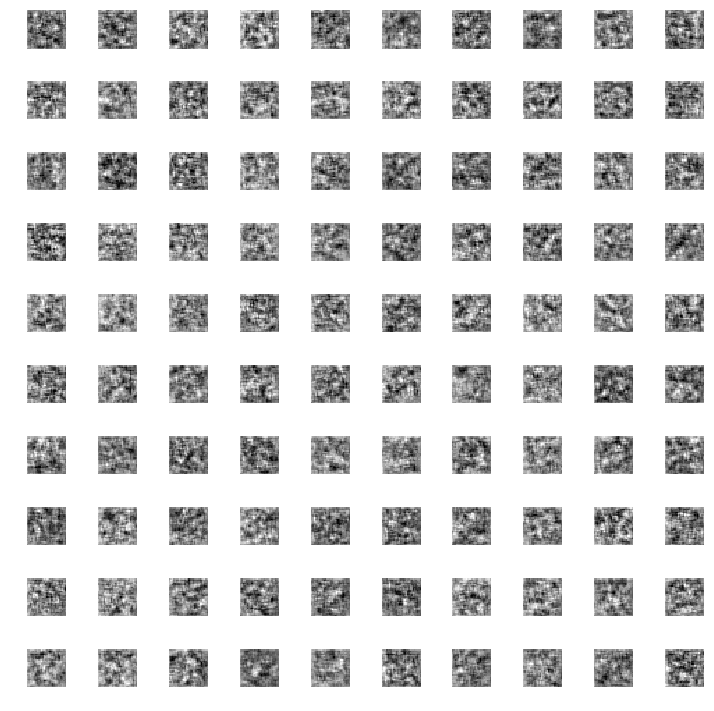

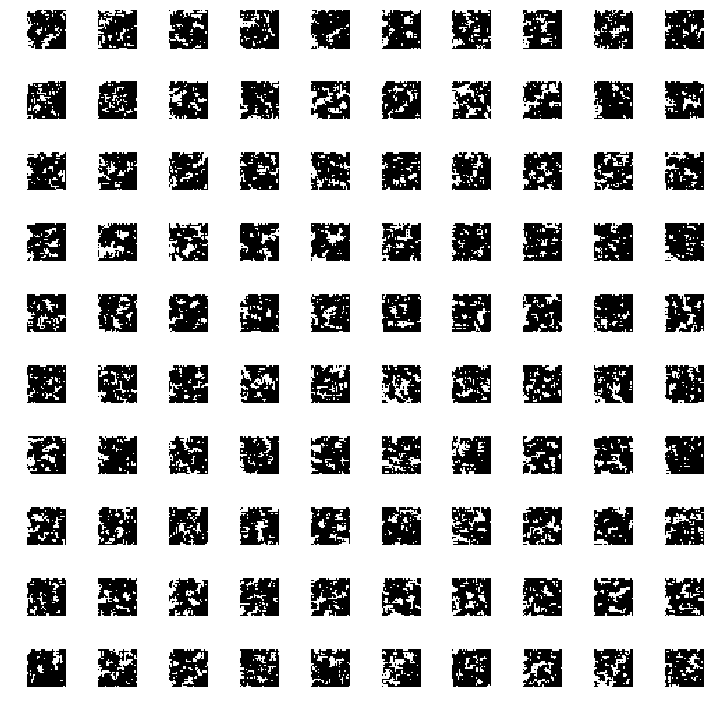

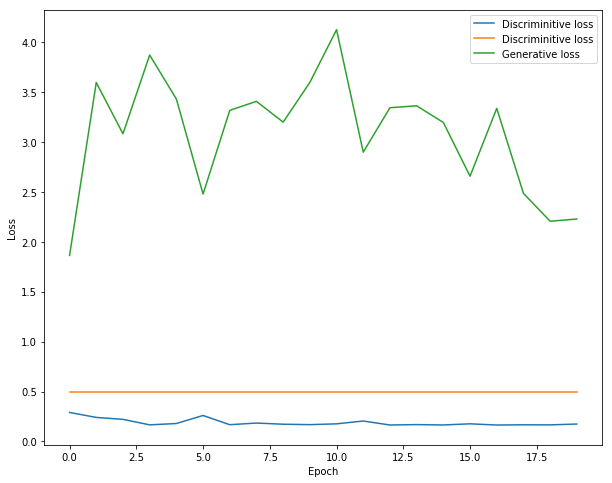

In [16]:
train(epochs, batch_size)